# Stroke Prediction: A Binary Classification Problem

1. [Problem Setting](#0)
2. [Setup: Importing Libraries and Data](#1)
3. [Exploratory Data Analysis (EDA)](#2)
4. [Data Preprocessing](#3)
5. [Feature Engineering & Selection](#4)
6. [Model Selection & Evaluation](#5)
7. [Conclusion](#7)


## Problem Setting <a id="0"></a>


In this notebook, I will work on a supervised binary classification problem to predict whether a subject is a stroke patient or not. The binary dependent target variable is `stroke` (1 if the patient had a stroke, 0 otherwise). The dataset contains 11 features including the target variable, which are as follows:

-   `id` (discrete): unique identifier
-   `gender` (discrete, binary): gender of the subject (`Male`, `Female`)
-   `age` (continuous): age of the subject in years
-   `hypertension` (discrete, binary): 0 if the subject doesn't have hypertension, 1 if the subject has hypertension
-   `heart_disease` (discrete, binary): 0 if the subject doesn't have any heart diseases, 1 if the subject has a heart disease
-   `work_type` (discrete): the type of occupation of the subject (`children`, `Govt_job`, `Never_worked`, `Private`, `Self-employed`)
-   `Residence_type` (discrete, binary): area type of residence of the subject (`Rural`, `Urban`)
-   `avg_glucose_level` (continuous): average glucose level in blood of the subject in mg/dL
-   `bmi` (continuous): body mass index of the subject in kg/m^2
-   `smoking_status` (discrete): the smoking status of the subject (`formerly smoked`, `never smoked`, `smokes`, `Unknown`)
-   target: `stroke` (discrete, binary): 1 if the subject had a stroke or 0 otherwise

The data is fictional. The data set used for training contains 5000 observations, whereas the test data consists of 1000 samples. The training set is imbalanced, with around 90 % of the samples containing the target value 0.

I will use the following metrics for evaluation:

-   Accuracy
-   Precision
-   Recall
-   F1 Score
-   ROC AUC Score
-   Confusion Matrix

Given that the data is imbalanced, accuracy can be misleading, and I will use the ROC AUC score as the main evaluation metric.

I will train two models, one linear model (Logistic Regression) and one non-linear model ((Deep) Neural Network), and compare their performance. Both of them will have the weighted cross-entropy loss function as criterion, to account for the class imbalance.


## Setup: Importing Libraries and Data <a id="1"></a>

First: import all necessary dependencies.


In [228]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))


import numpy as np
from loguru import logger
import pandas as pd

from src.data_preparation import load_data, min_max_normalize, replace_na, transform_non_numericals, create_polynomials, transform_polynomials, create_pca, transform_pca
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from src.training import BinaryLogisticRegression, BinaryNeuralNetwork, NaiveBaseline, evaluate, feature_selection, nested_cross_validation
from src.data_understanding import plot_distributions, print_na, print_non_numericals, plot_relative_distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting seed values for reproducibility:


In [229]:
# set seeds for sklearn, numpy, pandas
seed = 42
random.seed(seed)
np.random.seed(seed)
random_state = check_random_state(seed)

## Exploratory Data Analysis (EDA) <a id="2"></a>


### Data Exploration

By creating a first graphical representation of the data at hand, I will get a better understanding of the underlying distributions.


In [230]:
# load data
path_data_train = "data/train.csv"
path_data_test = "data/test.csv"

data_train_raw = load_data(base_path / path_data_train)
data_test_raw = load_data(base_path / path_data_test)

data_train_raw.drop(columns=["id"], inplace=True)
test_ids = data_test_raw["id"]
data_test_raw.drop(columns=["id"], inplace=True)

# print the number of `stroke` == 1 values
print(data_train_raw["stroke"].value_counts())

2024-08-03 18:51:56.789 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.

2024-08-03 18:51:56.798 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.



stroke
0    4502
1     498
Name: count, dtype: int64


I will plot the distributions of the raw data to get an initial understanding of what I am working with.


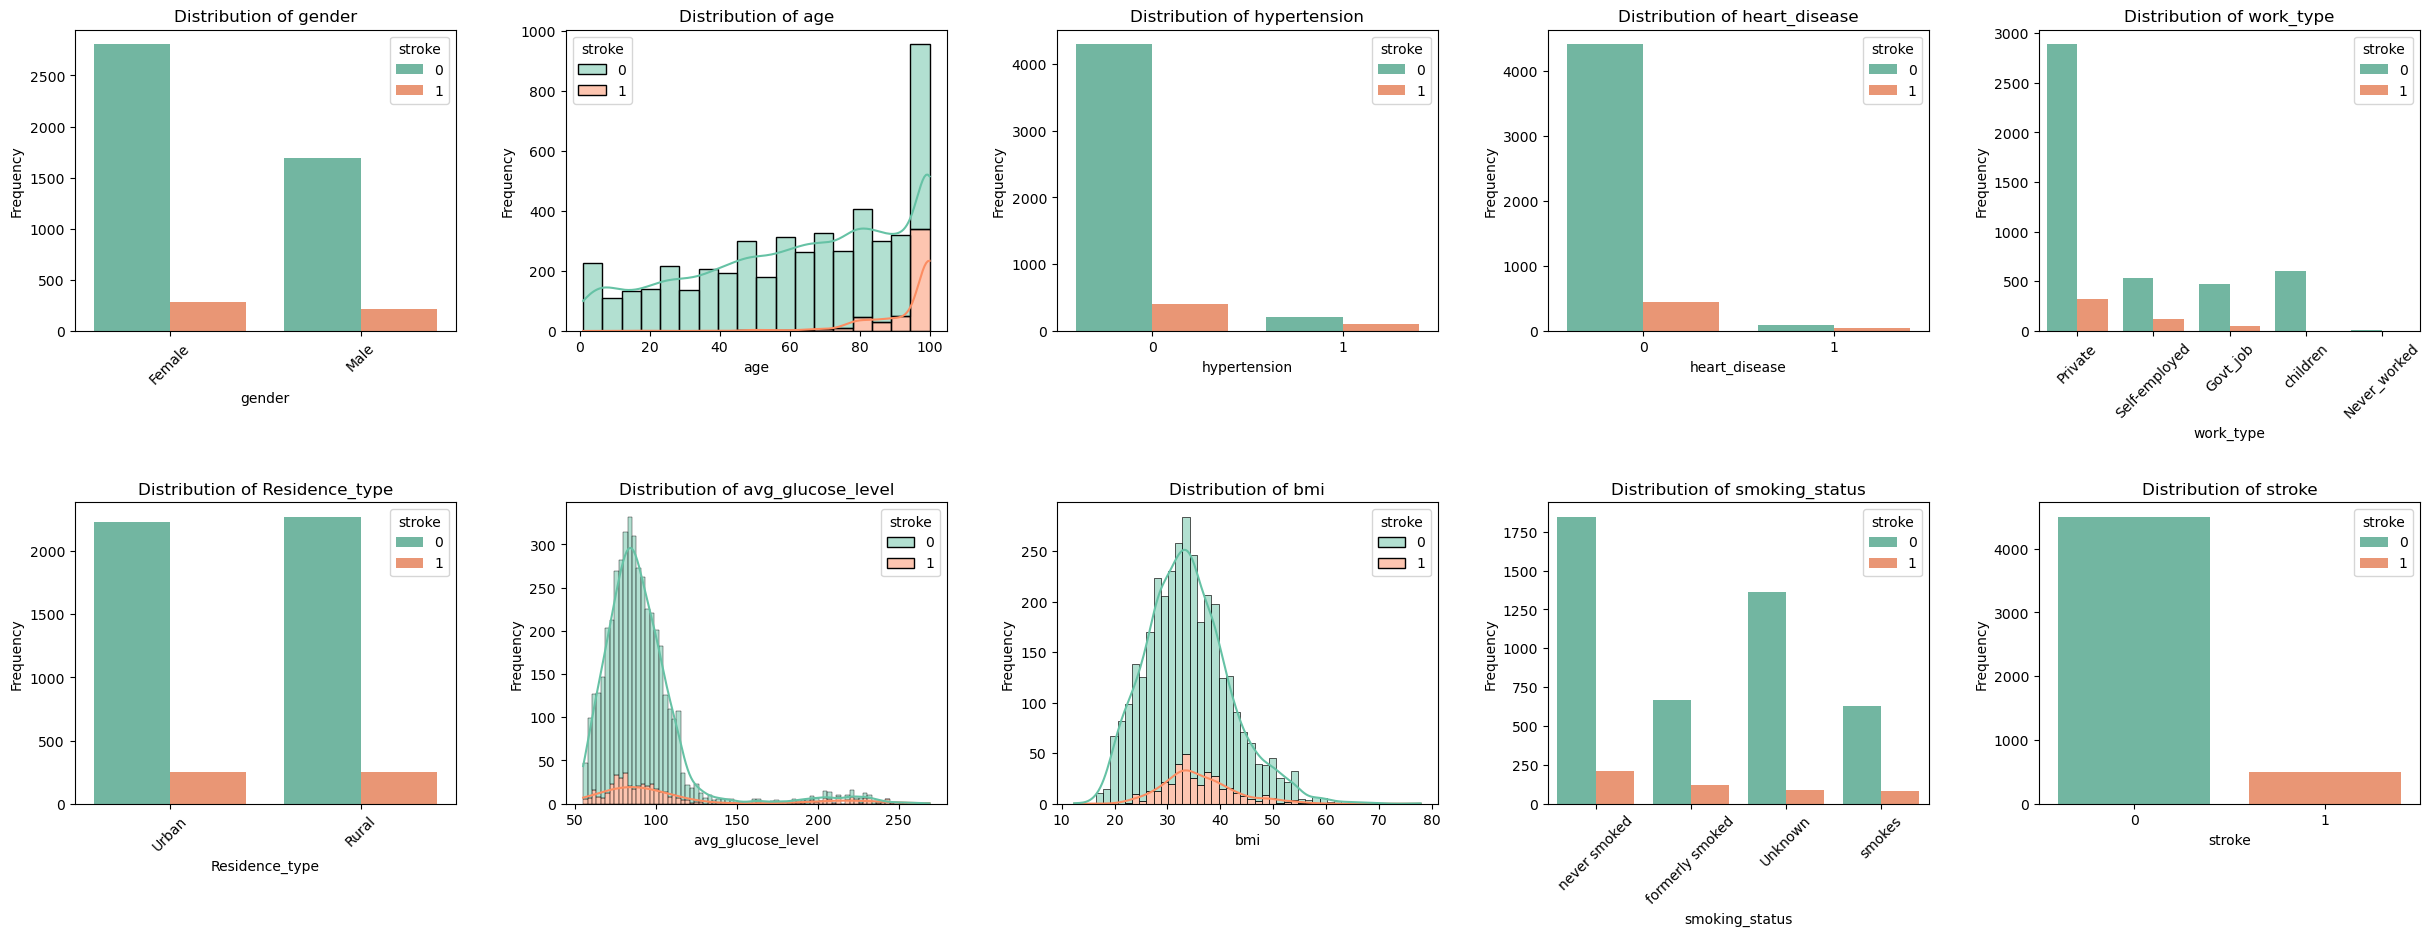

In [231]:
plot_distributions(data_train_raw)

Some important first insights:

-   The dataset is highly imbalanced: There are many more instances of people who did not have a stroke than those who did. This will require special attention during model training and evaluation.
-   There are a mix of numerical and categorical features. This will need to be taken care of during preprocessing.
-   Regarding the numerical features:
    -   The features have different scales. I will normalize them using min-max normalization.
-   Regarding the categorical features:
    -   Some categorical features are binary, while others have more than two values.
    -   The categorical features with more than two values are nominal, i.e., there is no inherent order in the categories. I will one-hot encode them.
        -   Note: The `smoking_status` feature could be interpreted as ordinal in some sense ("time since last cigarette"), however, the influence of this underlying order on the target variable is not clear. I will treat it as a nominal feature.


To make sure that the training and test data come from the same underlying distribution, plot the test data as well:


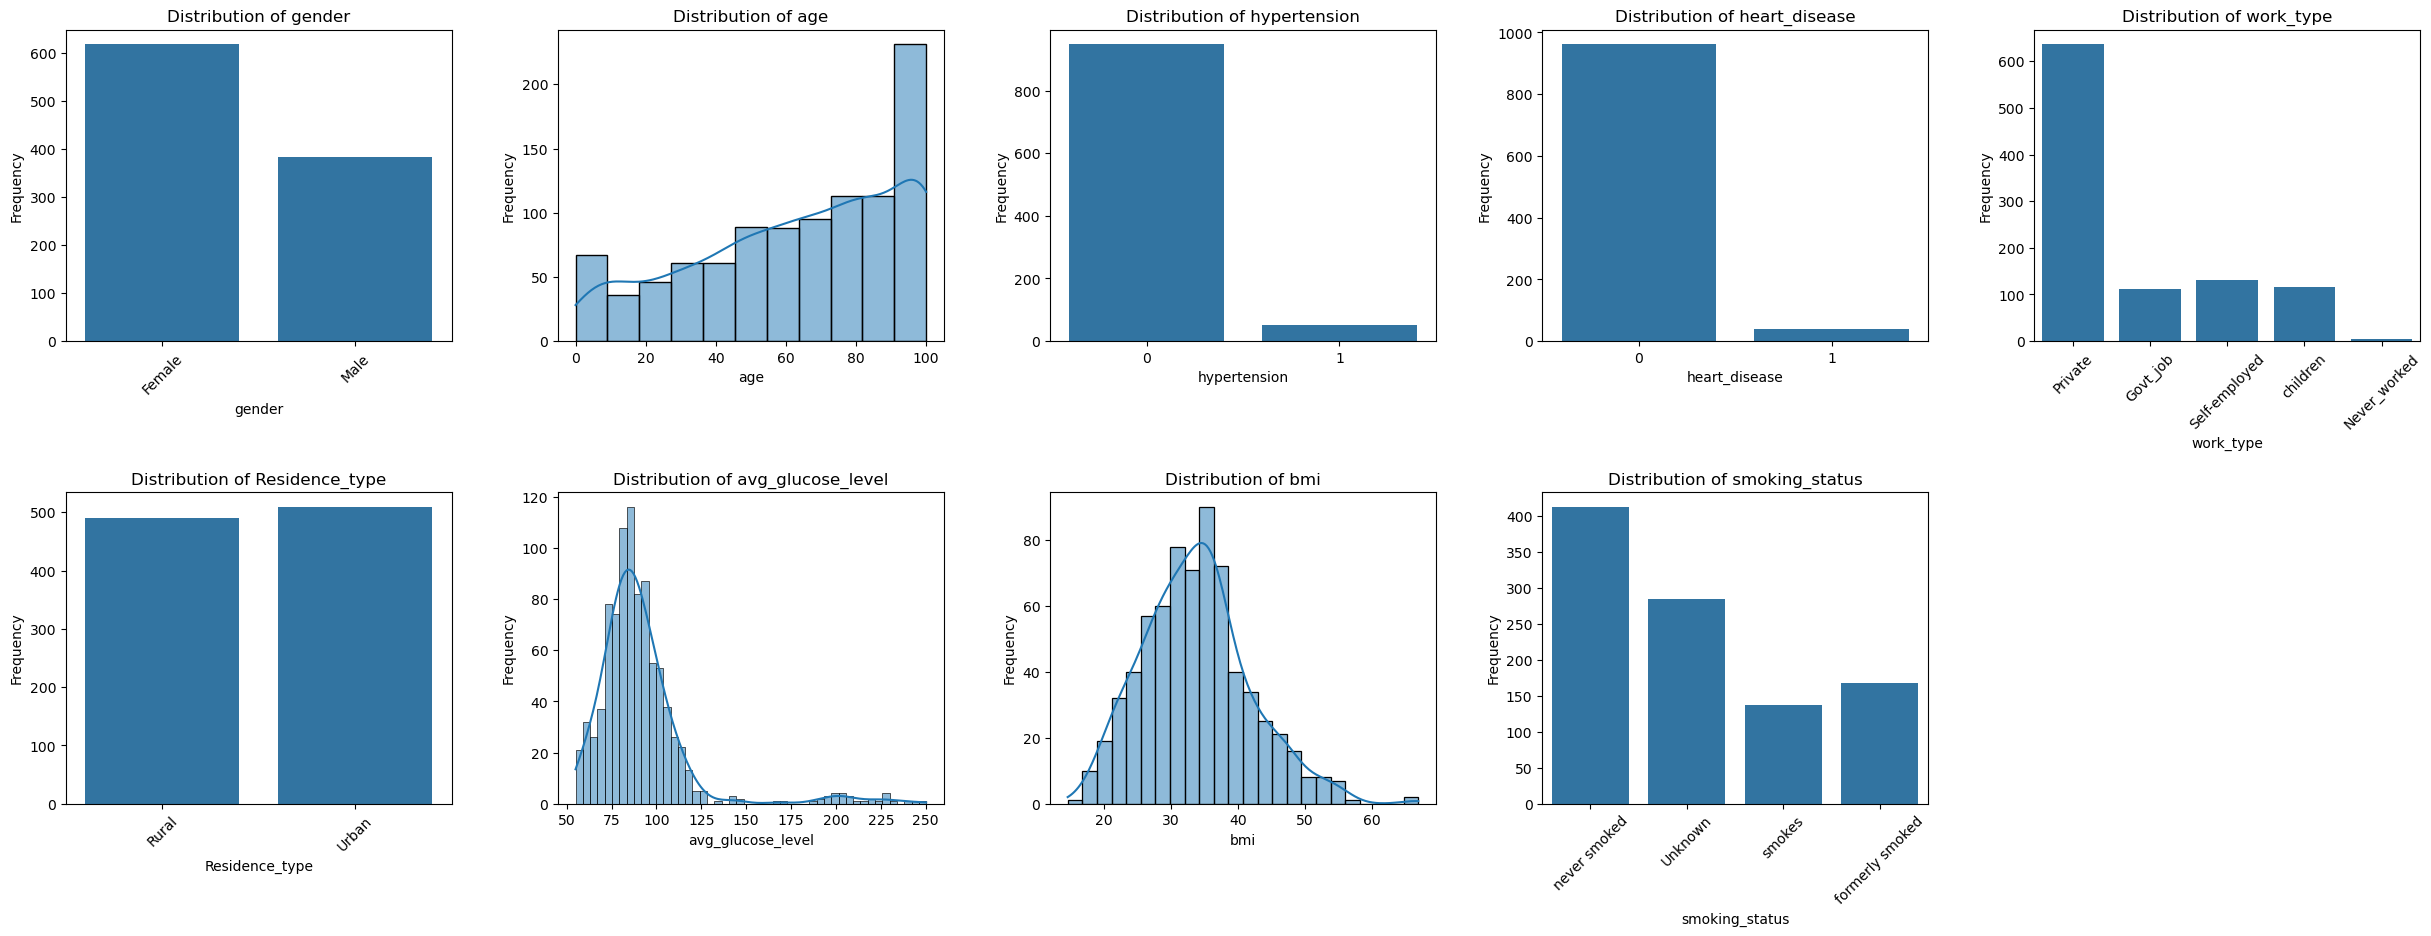

In [232]:
plot_distributions(data_test_raw)

Looks fine: No significant covariate shift is apparent. The distribution of some features, such as `smoking_status` and `work_type`, may differ slightly between the training and test data, but it seems more likely that the relatively small sample size creates this illusion.

Next, I'll have a look at the relative distributions of the target variable `stroke` over the features of the training data.


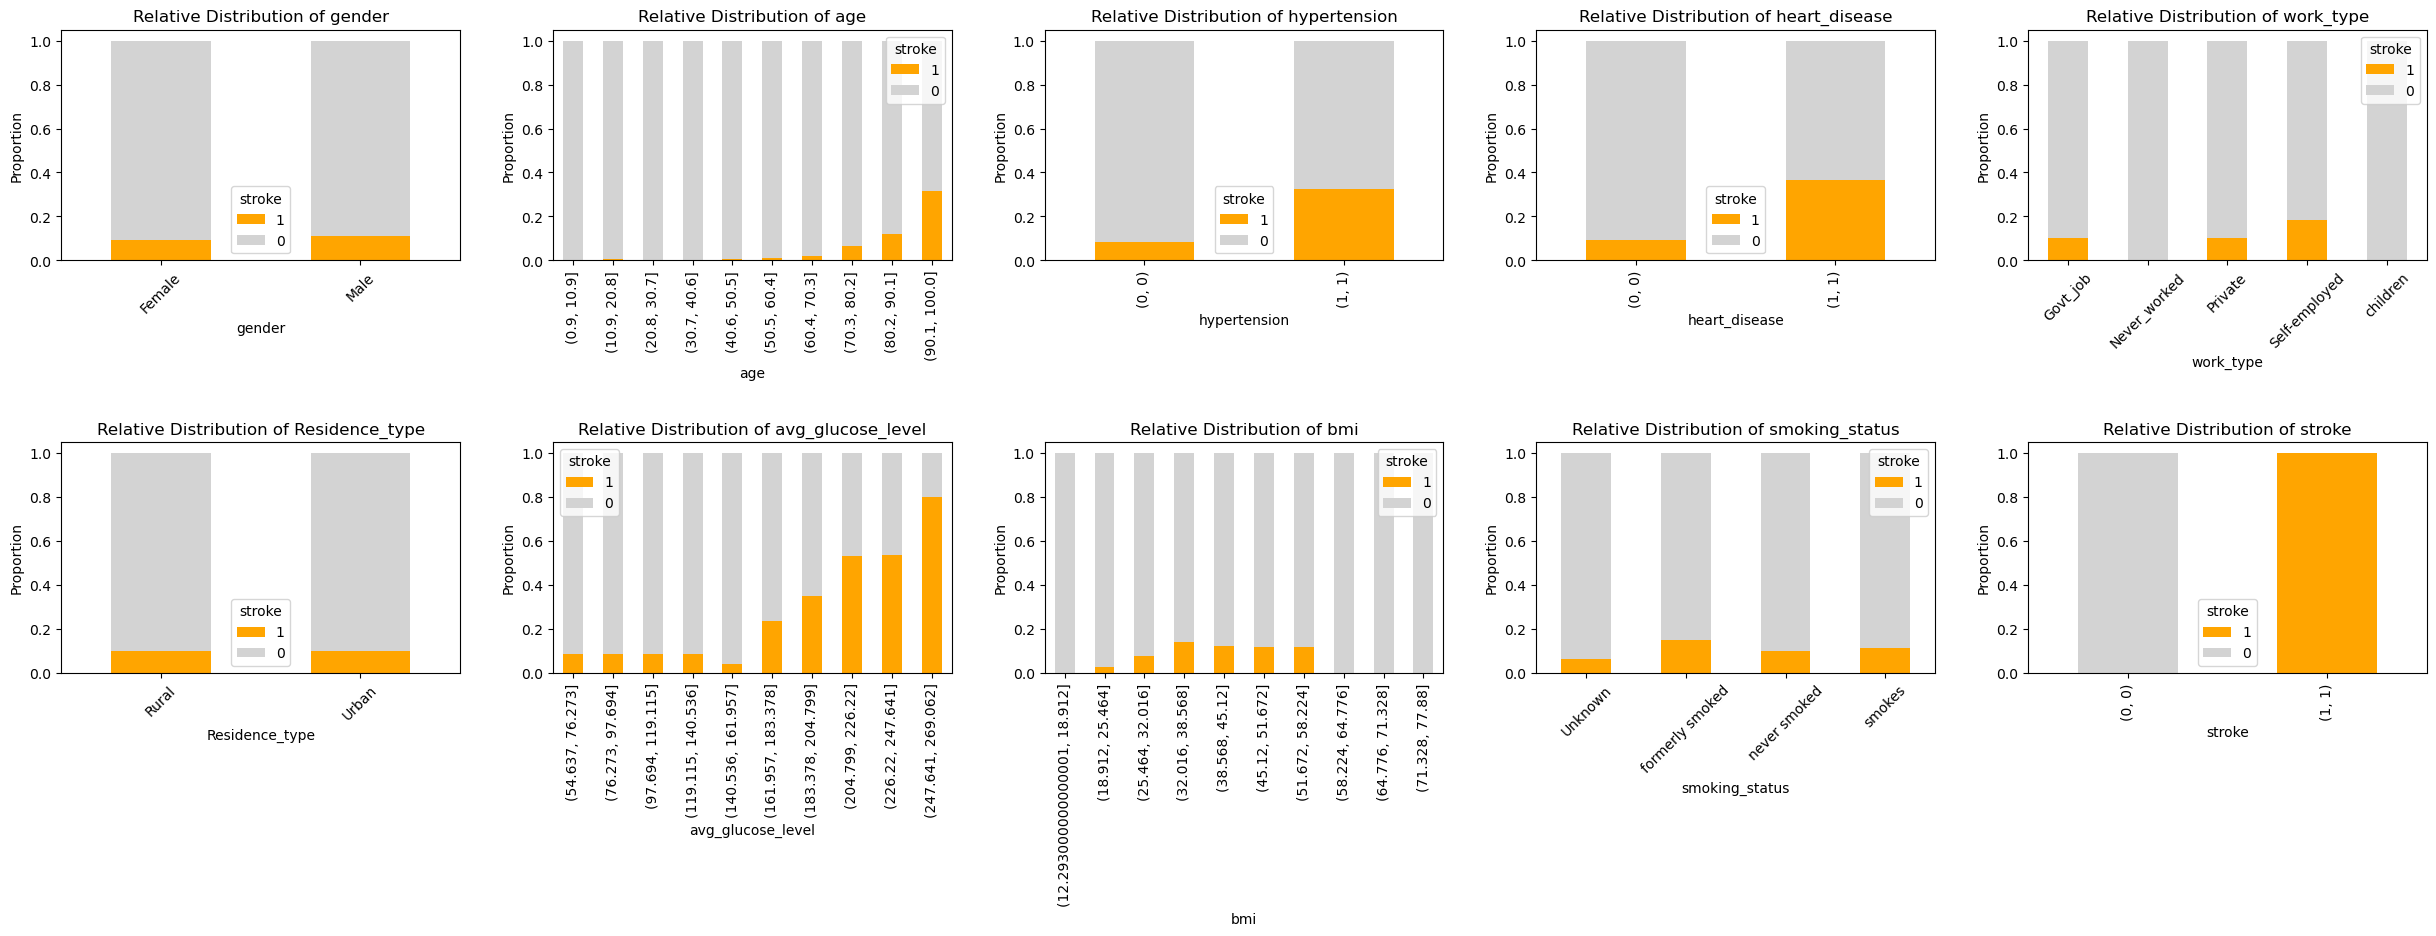

In [233]:
plot_relative_distributions(data_train_raw)

Some more important insights:

-   Regarding the continuous features:
    -   The relation of `age` and `bmi` with the likelihood of `stroke` seems to be positive and may be non-linear.
    -   `avg_glucose_level` might have a positive linear relation with target variable, potentially starting at a certain threshold.
-   Regarding the categorical features:
    -   `hypertension` and `heart_disease` seem to have a significant positive relation with the target variable.
    -   `work_type`: People who are self-employed seem to have a slightly higher chance of having a stroke. People who never worked or care for their children have a lower chance. Government workers and private workers seem to have a similar distribution.
    -   Both `gender` and `Residence_type` seem to have no significant influence on the target variable in isolation. However, there might be interaction effects with other features.

These are just first impressions. I did not test significance. Furthermore, I only yet looked at the features and their potential relationships with the target variable in isolation. Interaction effects may yet occur, and taking them into account by building polynomial features for the models may improve model performance.


In [234]:
print_na(data_train_raw)
print_non_numericals(data_train_raw)

2024-08-03 18:52:00.521 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column gender: 0 / 5000
2024-08-03 18:52:00.522 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column age: 0 / 5000
2024-08-03 18:52:00.523 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column hypertension: 0 / 5000
2024-08-03 18:52:00.523 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column heart_disease: 0 / 5000
2024-08-03 18:52:00.524 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column work_type: 0 / 5000
2024-08-03 18:52:00.525 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column Residence_type: 0 / 5000
2024-08-03 18:52:00.525 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column avg_glucose_leve

There are 2756 / 5000 data points with at least one missing value. This will need to be addressed in the preprocessing step. Since there are so many data points with missing values, I will not simply drop them.

-   For the continuous features `avg_glucose_level` and `bmi`, I will impute the missing values with the median of the respective feature.
-   For the categorical feature `smoking_status`, the missing values currently make up a separate category called "Unknown". I will treat this category as a separate category in the one-hot encoding step.


## Data Preprocessing <a id="3"></a>


In this section, I will preprocess the data to prepare it for model training. Specifically, I will:

-   Transform non-numerical features into numerical ones. This is done using one-hot encoding.
-   Replace missing values in the continuous features with the median of that respective feature, in order to retain as much information as possible.
-   Normalize the numerical features using min-max normalization. I will make all features have the same scale, which avoids gradient problems during neural network training.


In [235]:
data_train_preprocessed = transform_non_numericals(data_train_raw)
data_train_preprocessed = replace_na(data_train_preprocessed, replace_with="median")
data_train_preprocessed = min_max_normalize(data_train_preprocessed)

data_test_preprocessed = transform_non_numericals(data_test_raw)
data_test_preprocessed = replace_na(data_test_preprocessed, replace_with="median")
data_test_preprocessed = min_max_normalize(data_test_preprocessed)

X_original = data_train_preprocessed.drop(columns=["stroke"]).copy().to_numpy()
y_original = data_train_preprocessed["stroke"].copy().to_numpy()
X_test_original = data_test_preprocessed.copy().to_numpy()

X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(
    X_original, y_original, test_size=0.2
)

2024-08-03 18:52:00.570 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:30 - Transformed gender into binary encoding
2024-08-03 18:52:00.575 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-08-03 18:52:00.578 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-08-03 18:52:00.586 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:34 - Transformed smoking_status into one-hot encoding
2024-08-03 18:52:00.589 | INFO     | src.data_preparation.data_preprocessing:replace_na:17 - Replaced NaN values with median
2024-08-03 18:52:00.592 | INFO     | src.data_preparation.data_preprocessing:min_max_normalize:50 - Normalized data using min-max normalization
2024-08-03 18:52:00.593 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:30 - Transformed gen

## Feature Engineering & Selection <a id="4"></a>


Next, I will create new features by combining existing ones, using polynomials and Principal Component Analysis (PCA). This way, non-linear relationships between features and target can be mapped to linear relationships. This may allow the Logistic Regression model to find a seperation it would otherwise not be able to discover, given its linear nature. This might also help the Neural Network model to learn more efficiently, whereas the Neural Network may be able to learn more complex relationships between features and target, if they exist.

I will create these mappings &\Phi{X}$ explicitly and will be using primal decision functions in the models. Dual decision functions using polynomial kernel methods and computing the inverse of the kernel matrix would be feasible given the relatively small data set, but since the complexity of the models is not too high, the primal decision functions will be fine.

Apart from creating polynomial features, I will also use PCA to compute the principal components of the data, incorporating both the original features and the polynomial ones.

After creating the new features (polynomials and principal components), I will select the most relevant ones, reducing the dimensionality of the feature space to avoid overfitting and reduce training times. This will be done using backward selection, leveraging a Logistic Regression model by scikit-learn.


### Feature Engineering: Polynomial Features


I am going to create polynomial features of degree 2, so for each pair of features $\set{x_1, x_2}$ there will be a new set $\set{x_1 x_2, x_1^2, x_2^2}$ that will be added to the feature space.


In [236]:
d_poly = 2

# feature cols without target
feature_columns = data_train_preprocessed.columns.drop("stroke")

polynomials_train, feature_names = create_polynomials(
    data_train_preprocessed, feature_columns, degree=d_poly
)
print(f"Features in polynomial_train: {polynomials_train.columns}")
polynomials_test = transform_polynomials(data_test_preprocessed, feature_names)

logger.info(f"Data preprocessed train shape: {data_train_preprocessed.shape}")
logger.info(f"Data preprocessed test shape: {data_test_preprocessed.shape}")
logger.info(f"Polynomials train shape: {polynomials_train.shape}")
logger.info(f"Polynomials test shape: {polynomials_test.shape}")

2024-08-03 18:52:00.787 | INFO     | __main__:<module>:12 - Data preprocessed train shape: (5000, 17)
2024-08-03 18:52:00.788 | INFO     | __main__:<module>:13 - Data preprocessed test shape: (1000, 16)
2024-08-03 18:52:00.789 | INFO     | __main__:<module>:14 - Polynomials train shape: (5000, 153)
2024-08-03 18:52:00.789 | INFO     | __main__:<module>:15 - Polynomials test shape: (1000, 152)


Features in polynomial_train: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'work_type_Govt_job',
       'work_type_Never_worked',
       ...
       'smoking_status_Unknown^smoking_status_Unknown',
       'smoking_status_Unknown^smoking_status_formerly smoked',
       'smoking_status_Unknown^smoking_status_never smoked',
       'smoking_status_Unknown^smoking_status_smokes',
       'smoking_status_formerly smoked^smoking_status_formerly smoked',
       'smoking_status_formerly smoked^smoking_status_never smoked',
       'smoking_status_formerly smoked^smoking_status_smokes',
       'smoking_status_never smoked^smoking_status_never smoked',
       'smoking_status_never smoked^smoking_status_smokes',
       'smoking_status_smokes^smoking_status_smokes'],
      dtype='object', length=153)


There are a total of 152 features now. Next, I will add a total of eight principal components to the feature space.


In [237]:
n_pcs = 8

pcs_train, pca = create_pca(polynomials_train, feature_columns, n_components=n_pcs)
pcs_test = transform_pca(polynomials_test, pca, feature_columns)

logger.info(f"Principal components train shape: {pcs_train.shape}")
logger.info(f"Principal components test shape: {pcs_test.shape}")

2024-08-03 18:52:00.876 | INFO     | __main__:<module>:6 - Principal components train shape: (5000, 8)
2024-08-03 18:52:00.879 | INFO     | __main__:<module>:7 - Principal components test shape: (1000, 8)


In order to train the Logistic Regression model on all the features, I will group them together with the original features.


In [238]:
data_train_tmp = pd.concat([polynomials_train, pcs_train], axis=1)
data_test_tmp = pd.concat([polynomials_test, pcs_test], axis=1)

feature_names_tmp = data_train_tmp.drop(columns=["stroke"]).columns.to_list()

X_tmp = data_train_tmp.drop(columns=["stroke"]).copy().to_numpy()
y_tmp = data_train_tmp["stroke"].copy().to_numpy()
X_test_tmp = data_test_tmp.copy().to_numpy()

logger.info(f"First ten features in data_train_tmp: {feature_names_tmp[0:10]}")
logger.info(f"Last ten features in data_train_tmp: {feature_names_tmp[-10:]}")
logger.info(f"First ten features in data_test_tmp: {data_test_tmp.columns[0:10]}")
logger.info(f"Last ten features in data_test_tmp: {data_test_tmp.columns[-10:]}")

2024-08-03 18:52:01.121 | INFO     | __main__:<module>:10 - First ten features in data_train_tmp: ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private']
2024-08-03 18:52:01.123 | INFO     | __main__:<module>:11 - Last ten features in data_train_tmp: ['smoking_status_never smoked^smoking_status_smokes', 'smoking_status_smokes^smoking_status_smokes', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
2024-08-03 18:52:01.125 | INFO     | __main__:<module>:12 - First ten features in data_test_tmp: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private'],
      dtype='object')
2024-08-03 18:52:01.126 | INFO     | __main__:<module>:13 - Last ten features in data_test_tmp: Index(['smoking_status_never smoked^smoking_status_smokes',
       'smoking_stat

### Feature Selection


To select the most important features, I will leverage backward selection, training the scikit-learn Logistic Regression model with L1 regularization, effectively forcing competition between features, leading to the model setting many features' weights to 0. I will drop the five features with the weakest weights per iteration. The features that the model with the lowest empirical risk estimate used will be the final ones used for training the models. An error margin will be used to tendencially remove more features if the decrease of empirical risk is below the threshold.


i = 0 / 159 – Empirical Risk Estimate: 0.40703317075550705, Previous Estimate: inf – new number of features to delete – new lowest risk estimate
i = 5 / 159 – Empirical Risk Estimate: 0.40703320263676535, Previous Estimate: 0.40703317075550705 – new number of features to delete
i = 10 / 159 – Empirical Risk Estimate: 0.4070334681146294, Previous Estimate: 0.40703320263676535 – new number of features to delete
i = 15 / 159 – Empirical Risk Estimate: 0.4070336031092932, Previous Estimate: 0.4070334681146294 – new number of features to delete
i = 20 / 159 – Empirical Risk Estimate: 0.40703348755395574, Previous Estimate: 0.4070336031092932 – new number of features to delete
i = 25 / 159 – Empirical Risk Estimate: 0.40703379953955393, Previous Estimate: 0.40703348755395574 – new number of features to delete
i = 30 / 159 – Empirical Risk Estimate: 0.40703381318141657, Previous Estimate: 0.40703379953955393 – new number of features to delete
i = 35 / 159 – Empirical Risk Estimate: 0.40703343

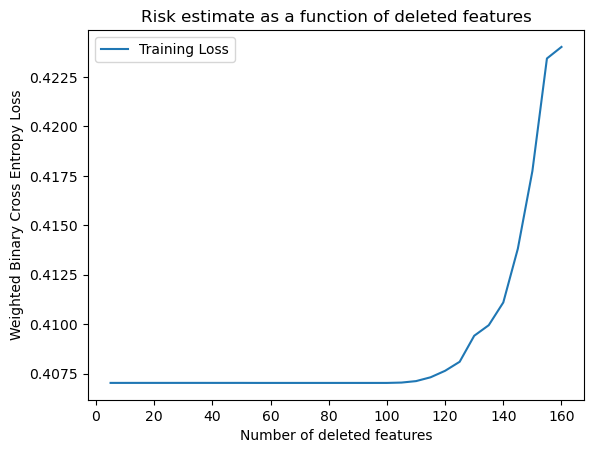

Features to delete (135, thereof unique 135): [0, 102, 101, 144, 99, 1, 118, 117, 116, 115, 2, 90, 89, 139, 87, 126, 125, 58, 95, 56, 135, 119, 120, 54, 53, 96, 39, 140, 41, 42, 105, 37, 143, 142, 111, 122, 34, 150, 131, 149, 71, 134, 133, 132, 129, 69, 137, 136, 123, 121, 66, 141, 138, 114, 110, 64, 24, 145, 109, 108, 147, 46, 47, 92, 146, 65, 30, 91, 67, 148, 78, 74, 77, 23, 157, 61, 103, 151, 19, 84, 107, 68, 5, 6, 7, 154, 8, 10, 11, 12, 13, 14, 15, 16, 17, 3, 49, 44, 128, 57, 124, 50, 43, 72, 97, 153, 70, 18, 83, 25, 28, 127, 85, 94, 36, 75, 158, 33, 62, 59, 63, 20, 130, 29, 9, 40, 31, 113, 156, 73, 48, 26, 4, 82, 52]


In [239]:
n_features_per_iteration = 5  # delete 5 features per iteration
risk_estimate_error_margin = 0.005  # metric: weighted binary cross entropy loss

features_to_delete, risk_estimates = feature_selection(
    X_tmp,
    y_tmp,
    n_features_per_iteration=n_features_per_iteration,
    risk_estimate_error_margin=risk_estimate_error_margin,
    plot=True,
)
print(
    f"Features to delete ({len(features_to_delete)}, thereof unique {len(set(features_to_delete))}): {features_to_delete}"
)

Creating new references `X_train_selected`, `X_val_selected` and `X_test_selected`:


In [240]:
# drop the features
logger.info(f"Shape of X_tmp before feature selection: {X_tmp.shape}")
logger.info(f"Shape of X_test_selected before feature selection: {X_test_tmp.shape}")

X_selected = np.delete(X_tmp, features_to_delete, axis=1)
y_selected = y_tmp
X_test_selected = np.delete(X_test_tmp, features_to_delete, axis=1)

X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(
    X_selected, y_selected, test_size=0.2
)

logger.info(
    f"Shape of X_train_selected after feature selection: {X_train_selected.shape}"
)
logger.info(f"Shape of X_val_selected after feature selection: {X_val_selected.shape}")
logger.info(
    f"Shape of X_test_selected after feature selection: {X_test_selected.shape}"
)

2024-08-03 18:52:29.670 | INFO     | __main__:<module>:2 - Shape of X_tmp before feature selection: (5000, 160)
2024-08-03 18:52:29.672 | INFO     | __main__:<module>:3 - Shape of X_test_selected before feature selection: (1000, 160)
2024-08-03 18:52:29.678 | INFO     | __main__:<module>:13 - Shape of X_train_selected after feature selection: (4000, 25)
2024-08-03 18:52:29.679 | INFO     | __main__:<module>:16 - Shape of X_val_selected after feature selection: (1000, 25)
2024-08-03 18:52:29.680 | INFO     | __main__:<module>:17 - Shape of X_test_selected after feature selection: (1000, 25)


## Model Selection & Evaluation <a id="5"></a>


I will first present the Naive Baseline model. Each prediction here is as likely to be positive as the probability to encounter a positive class in the training data given one draw. I will use this as a baseline to compare the other models against.

After that, for each model I will use an implementation of nested cross-validation to optimize the hyperparameters for the model and evaluate its performance. The nested cross-validation scheme consists of an outer loop with five folds and an inner loop with a five-fold cross-validation that does a grid-search on all combinations of hyperparameters given to the function, with the weighted binary cross-entropy loss as risk metric. The evaluation metrics after hyperparameter tuning will be the ROC AUC score, the F1 score, the confusion matrix, and the precision and recall scores. The accuracy will be reported as well, but it will not be used for model selection, given the class imbalance. The best model will be selected based on the ROC AUC score and will be used to predict the target variable on the test data.

I will train a linear logistic regression model and a non-linear neural network model. I decided for these two models because they allow to compare a linear approach with a non-linear one whuile maintaining similar structures: Neural Networks can be regarded as an extension of logistic regression models, with additional non-linear transformations of the input through activation functions and thus, more complex decision boundaries. This comparison is especially interesting given the polynomial features taht were previously created. The logistic regression model will use these features directly, whereas the neural network model is free to derive even more complex relationships from its input. It is to be seen if this additional complexity is beneficial, counterproductive, or irrelevant.


### Naive Baseline


2024-08-03 18:52:29.720 | INFO     | src.training.evaluate:evaluate:40 - Naive Baseline – Empirical Risk Estimate: 1.1995535033256972, Accuracy: 0.837, F1 score: 0.1092896174863388, Precision: 0.11235955056179775, Recall: 0.10638297872340426, AUC: 0.5
            Pred Neg  Pred Pos
Actual Neg       827        79
Actual Pos        84        10


Validation accuracy: 0.826


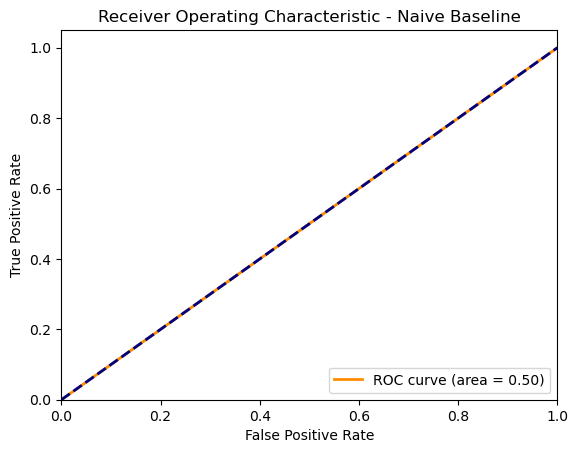

(1.1995535033256972, 0.837, 0.1092896174863388, 0.5)

In [241]:
# Naive Baseline
naive_baseline = NaiveBaseline()
naive_baseline.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected)
y_pred = naive_baseline.predict(X_val_selected)
y_pred_proba = naive_baseline.predict_proba(X_val_selected)
evaluate("Naive Baseline", y_val_selected, y_pred, y_pred_proba, plot=True)

The results here match expectations: The Naive Model has an Area Under the Curve (AUC) of 0.5, which means it is as good as random: The probability that a randomly positive instance gets higher output score than a randomly drawn negative instance is 50%.

Recall and precision are low, which is expected given the random nature of the model. The accucary is relatively high, which is due to the imbalance of the data, but it is not a good metric to evaluate the model's performance in this case.

Next, I will train the Logistic Regression model on the selected features.


### Logistic Regression


#### Nested Cross-Validation


In [242]:
param_grid_lr = {
    "n_features": [X_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.1, 0.01, 0.001],
}

Performing nested cross-validation for model Binary Logistic Regression with 5000 samples
Empirical risk estimate for fold 1 / 5, parameter set 1 / 27: 0.5690388915268664
Empirical risk estimate for fold 1 / 5, parameter set 2 / 27: 0.45026182176107354
Empirical risk estimate for fold 1 / 5, parameter set 3 / 27: 0.41594850289070723
Empirical risk estimate for fold 1 / 5, parameter set 4 / 27: 0.5683223815249565
Empirical risk estimate for fold 1 / 5, parameter set 5 / 27: 0.4506193103453623
Empirical risk estimate for fold 1 / 5, parameter set 6 / 27: 0.42218297032112195
Empirical risk estimate for fold 1 / 5, parameter set 7 / 27: 0.5739311445152722
Empirical risk estimate for fold 1 / 5, parameter set 8 / 27: 0.4987906733118094
Empirical risk estimate for fold 1 / 5, parameter set 9 / 27: 0.4889946723755485
Empirical risk estimate for fold 1 / 5, parameter set 10 / 27: 0.5695028608455017
Empirical risk estimate for fold 1 / 5, parameter set 11 / 27: 0.4471067358275861
Empirical risk

2024-08-03 18:56:33.482 | INFO     | src.training.evaluate:evaluate:40 - Binary Logistic Regression – Empirical Risk Estimate: 0.41280955087787574, Accuracy: 0.759, F1 score: 0.41646489104116224, Precision: 0.273015873015873, Recall: 0.8775510204081632, AUC: 0.8886374949092719
            Pred Neg  Pred Pos
Actual Neg       673       229
Actual Pos        12        86


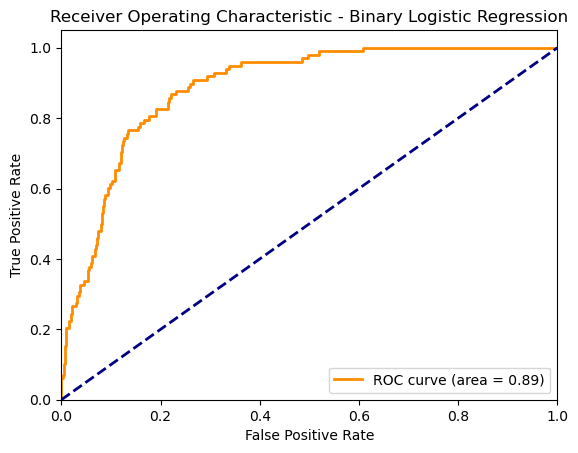

Empirical risk estimate on outer validation set: 0.41280955087787574
Epoch 0: Train Loss: 0.5324837996324842, Val Loss: 0.47104785126250465
Epoch 1: Train Loss: 0.45723660303926134, Val Loss: 0.44262231545353914
Epoch 2: Train Loss: 0.44067328765665587, Val Loss: 0.4328225498618169
Epoch 3: Train Loss: 0.4341055282364013, Val Loss: 0.4282643138111329
Epoch 4: Train Loss: 0.4307720996560411, Val Loss: 0.4257224797581293
Epoch 5: Train Loss: 0.42879916738890494, Val Loss: 0.42412658738701303
Epoch 6: Train Loss: 0.4275070036899499, Val Loss: 0.4230408520925801
Epoch 7: Train Loss: 0.42660008984868936, Val Loss: 0.42225937219281356
Epoch 8: Train Loss: 0.4259315580248379, Val Loss: 0.4216732656373767
Epoch 9: Train Loss: 0.42542062105431905, Val Loss: 0.4212197851560934
Epoch 10: Train Loss: 0.4250192445455875, Val Loss: 0.4208602955778197
Epoch 11: Train Loss: 0.4246970889101163, Val Loss: 0.42056974333299424
Epoch 12: Train Loss: 0.42443405103375864, Val Loss: 0.4203311932368135
Epoch 1

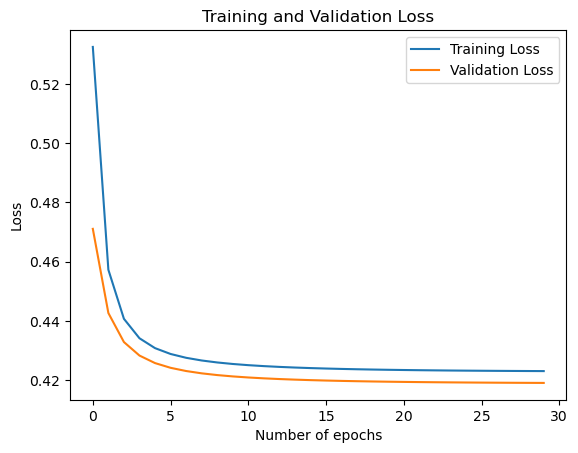

Training complete.
Fitted final model on entire dataset


In [243]:
k = 5

lr_final, lr_params, lr_R_est, lr_acc, lr_f1, lr_auc = nested_cross_validation(
    X_selected,
    y_selected,
    BinaryLogisticRegression,
    param_grid_lr,
    k=k,
)

The nested cross-validation scheme has found the best hyperparameters for the Logistic Regression model: {'epochs': 30, 'learning_rate': 0.1, 'lambda_reg': 0.001}

The model seems to converge. It does not seem to be overfitting. The AUC is around 0.89 on the validation set (1000 samples), indicating the model's ability to separate classes. The precision is relatively low, while the recall is relatively high. The penalty weights that were used to counteract the imbalanced dataset made the model more liberal, and it may have some difficulty to separate classes. The model's tendency to lean towards positive predictions is further reflected by the confusion matrix.


### Neural Network


#### Nested Cross-Validation


In [244]:
param_grid_nn = {
    "n_features": [X_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.1, 0.01, 0.001],
    "n_hidden_units": [16, 32, 64],
    "n_hidden_layers": [1, 2],
}

Performing nested cross-validation for model Binary Neural Network with 5000 samples
Empirical risk estimate for fold 1 / 5, parameter set 1 / 162: 0.45768397269468364
Empirical risk estimate for fold 1 / 5, parameter set 2 / 162: 0.46805921451566634
Empirical risk estimate for fold 1 / 5, parameter set 3 / 162: 0.4635586056972826
Empirical risk estimate for fold 1 / 5, parameter set 4 / 162: 0.46992478127646303
Empirical risk estimate for fold 1 / 5, parameter set 5 / 162: 0.4628238214331333
Empirical risk estimate for fold 1 / 5, parameter set 6 / 162: 0.46742735142532255
Empirical risk estimate for fold 1 / 5, parameter set 7 / 162: 0.43578414499480755
Empirical risk estimate for fold 1 / 5, parameter set 8 / 162: 0.4372235189386203
Empirical risk estimate for fold 1 / 5, parameter set 9 / 162: 0.44218502754356237
Empirical risk estimate for fold 1 / 5, parameter set 10 / 162: 0.4378152594824673
Empirical risk estimate for fold 1 / 5, parameter set 11 / 162: 0.4386024492945241
Empir

2024-08-03 19:23:33.934 | INFO     | src.training.evaluate:evaluate:40 - Binary Neural Network – Empirical Risk Estimate: 0.4489129766077429, Accuracy: 0.766, F1 score: 0.4375, Precision: 0.29260450160771706, Recall: 0.8666666666666667, AUC: 0.8718808193668529
            Pred Neg  Pred Pos
Actual Neg       675       220
Actual Pos        14        91


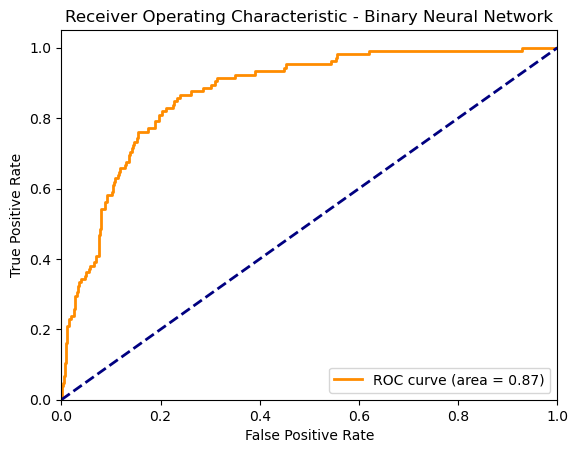

Empirical risk estimate on outer validation set: 0.4489129766077429
Epoch 0: Train Loss: 0.6432740478762922, Val Loss: 0.5746270695498914
Epoch 1: Train Loss: 0.5288000265741838, Val Loss: 0.48721425386027706
Epoch 2: Train Loss: 0.4694488130588429, Val Loss: 0.45028515805166897
Epoch 3: Train Loss: 0.44579667207974955, Val Loss: 0.43520151849355404
Epoch 4: Train Loss: 0.435504118253017, Val Loss: 0.42809953778321286
Epoch 5: Train Loss: 0.4308526103681512, Val Loss: 0.42500887950560456
Epoch 6: Train Loss: 0.4286655605131632, Val Loss: 0.42327758375400937
Epoch 7: Train Loss: 0.4273984216403475, Val Loss: 0.42223635410433796
Epoch 8: Train Loss: 0.42660292909453285, Val Loss: 0.42148491741476535
Epoch 9: Train Loss: 0.4260696187532932, Val Loss: 0.4209176393431998
Epoch 10: Train Loss: 0.42557665310904647, Val Loss: 0.420379265522495
Epoch 11: Train Loss: 0.42522362010820286, Val Loss: 0.42005456667732777
Epoch 12: Train Loss: 0.42494368382068104, Val Loss: 0.4197542729617941
Epoch 1

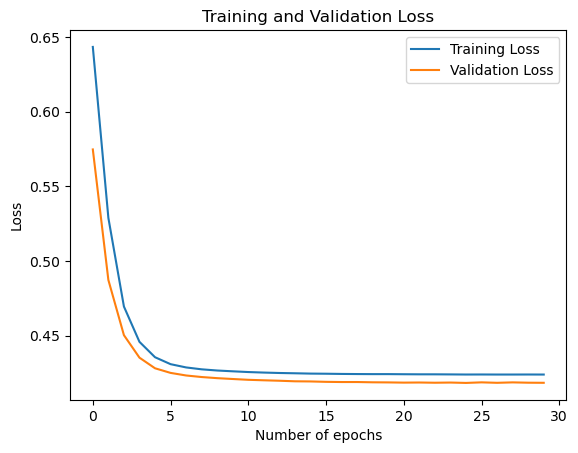

Training complete.
Fitted final model on entire dataset


In [245]:
k = 5

nn_final, nn_params, nn_R_est, nn_acc, nn_f1, nn_auc = nested_cross_validation(
    X_selected,
    y_selected,
    BinaryNeuralNetwork,
    param_grid_nn,
    k=k,
)

The Neural Network model has found the best hyperparameters: {'epochs': 30, 'learning_rate': 0.05, 'lambda_reg': 0.01, 'n_hidden_units': 16, 'n_hidden_layers': 1}

The model seems to converge. It does not seem to be overfitting. Similar to the Logistic Regression Model, the Neural Network tends to be liberal in its predictions: The precision is relatively low, while the recall is relatively high. The F1 score, the recall, and the precision are better in the Neural Network compared to the Logistic Regression model. The confusion matrix reflects the model's tendency to lean towards positive predictions. However, the AUC is around 0.87 on the validation set (1000 samples), cutting behind the Logistic Regression Model. Given the polynomial features that already capture non-linear relationships between features and target, the additional complexity of the Neural Network model may not be very helpful.


Given the better AUC score of the Logistic Regression model, I will use latter to make predictions on the test data and store them as a CSV file to submit.


In [227]:
y_pred_final = lr_final.predict_proba(X_test_selected)

# save predictions as csv in the format id,stroke
path_predictions = "data/predictions.csv"
predictions = pd.DataFrame({"id": test_ids, "stroke": y_pred_final})
predictions.to_csv(base_path / path_predictions, index=False)

## Conclusion <a id="7"></a>


In this notebook, I engaged in a binary classification problem to predict stroke occurences in subjects, using both a Logistic Regression model and a Neural Network model. Despite the ability of the Neural Network to handle non-linear relationships in the data, it did not outperform the Logistic Regression model, which achieved an AUC score of 0.89 compared to the Neural Network's 0.87 on the validation set. This suggests that the polynomial features that were created during the feature engineering step already capture the necessary complexity, making the additional complexity of the Neural Network redundant. Given the results, Logistic Regression is the better choice for this data set regarding the AUC metric, however, the neural network outperforms the Logistic Regression model's precision and recall.
